In [645]:
def load_data(name):
    performance = pd.read_parquet(f'{name}.parquet')
    performance = performance[performance['id']<300]
    performance = pd.concat([performance, pd.read_parquet(f'{name}3.parquet'), pd.read_parquet(f'{name}4.parquet')])
    return performance

In [646]:
import pandas as pd

datasets = pd.concat([pd.read_parquet('sarima_AR_monthly.parquet'), pd.read_parquet('sarima_AR5_monthly.parquet'), pd.read_parquet('sarima_AR.parquet'), pd.read_parquet('sarima_AR_daily2.parquet')])
distr = datasets[['id', 'distr', 'mc', 'batch']].drop_duplicates()
distr['model_details'] = distr['batch']

errors = load_data('errors') #.merge(distr, on=['id', 'batch'], how='left')
performance = load_data('performance').merge(distr, on=['id', 'model_details'], how='left')
features = load_data('features').merge(distr, on=['id', 'model_details'], how='left')

In [647]:
#pd.read_parquet(f'errors3.parquet').merge(pd.read_parquet('sarima_AR5_monthly.parquet')[['id', 'distr', 'mc', 'batch']].drop_duplicates(), on=['id']).groupby(['batch', 'distr', 'error']).count()

In [648]:
#errors['error']

# Prediction intervals

In [649]:
performance.tail()

,mape,pi,fold,n,is_normal,model,id,model_details,data,distr,mc,batch
24694,0.045438,0.714286,4,234,False,RandomForestTimeSeriesModel,AR_daily2_299,daily_7ahead2,AR,tstud_infinite,99,daily_7ahead2
24695,0.016247,1.000000,3,174,False,RandomForestTimeSeriesModel,AR_daily2_299,daily_7ahead2,AR,tstud_infinite,99,daily_7ahead2
24696,0.007581,1.000000,2,114,False,RandomForestTimeSeriesModel,AR_daily2_299,daily_7ahead2,AR,tstud_infinite,99,daily_7ahead2
24697,0.034587,0.571429,1,54,False,RandomForestTimeSeriesModel,AR_daily2_299,daily_7ahead2,AR,tstud_infinite,99,daily_7ahead2
24698,0.025870,0.857143,test,721,False,RandomForestTimeSeriesModel,AR_daily2_299,daily_7ahead2,AR,tstud_infinite,99,daily_7ahead2


In [650]:
pi =pd.pivot_table(data=performance, columns='distr', index=['batch', 'model'], aggfunc='mean', values='pi')
pi

distr                                          normal  tstud_finite  \
batch           model                                                 
daily_7ahead    RandomForestTimeSeriesModel  0.797033      0.797473   
                SARIMAXTimeSeriesModel       0.791597      0.905495   
daily_7ahead2   RandomForestTimeSeriesModel  0.791099      0.792198   
                SARIMAXTimeSeriesModel       0.789121      0.905824   
monthly5_3ahead RandomForestTimeSeriesModel  0.766250      0.768333   
                SARIMAXTimeSeriesModel       0.730000      0.840132   

distr                                        tstud_infinite  
batch           model                                        
daily_7ahead    RandomForestTimeSeriesModel        0.790659  
                SARIMAXTimeSeriesModel             0.964945  
daily_7ahead2   RandomForestTimeSeriesModel        0.796374  
                SARIMAXTimeSeriesModel             0.964286  
monthly5_3ahead RandomForestTimeSeriesModel        0.713125  
                SARIMAXTimeSeriesModel             0.882092

In [482]:
print(pi.to_latex())

\begin{tabular}{llrrr}
\toprule
                & distr &    normal &  tstud\_finite &  tstud\_infinite \\
batch & model &           &               &                 \\
\midrule
daily\_7ahead & RandomForestTimeSeriesModel &  0.797033 &      0.797473 &        0.790659 \\
                & SARIMAXTimeSeriesModel &  0.791597 &      0.905495 &        0.964945 \\
monthly5\_3ahead & RandomForestTimeSeriesModel &  0.766250 &      0.768333 &        0.713125 \\
                & SARIMAXTimeSeriesModel &  0.730000 &      0.840132 &        0.882092 \\
\bottomrule
\end{tabular}



In [651]:
def plot_distr(distr, ax):
    subset = performance[(performance['distr']==distr) & (performance['batch']==batch)].copy()
    subset = subset[subset['n']>24]
    subset['i'] = subset.index
    subset['theoretical'] = 0.8

    pd.pivot_table(subset, index='i', columns='model', values='pi').plot.kde(bw_method=0.5, title=distr, ax=ax)
    ax.axvline(0.8, color='grey', linestyle='-')

    m = subset.loc[(subset['distr']==distr) & (subset['model']=='RandomForestTimeSeriesModel'), 'pi'].median()
    ax.axvline(m, color='#1f77b4', linestyle='--')
    ax.text(m-0.1, 0.2, str(round(m, 2)), c='#1f77b4')

    m = subset.loc[(subset['distr']==distr) & (subset['model']=='SARIMAXTimeSeriesModel'), 'pi'].median()
    ax.axvline(m, color='tab:orange', linestyle='--')
    ax.text(m, 0.2, str(round(m, 2)), c='tab:orange')
    
    return ax

<AxesSubplot:title={'center':'tstud_infinite'}, ylabel='Density'>

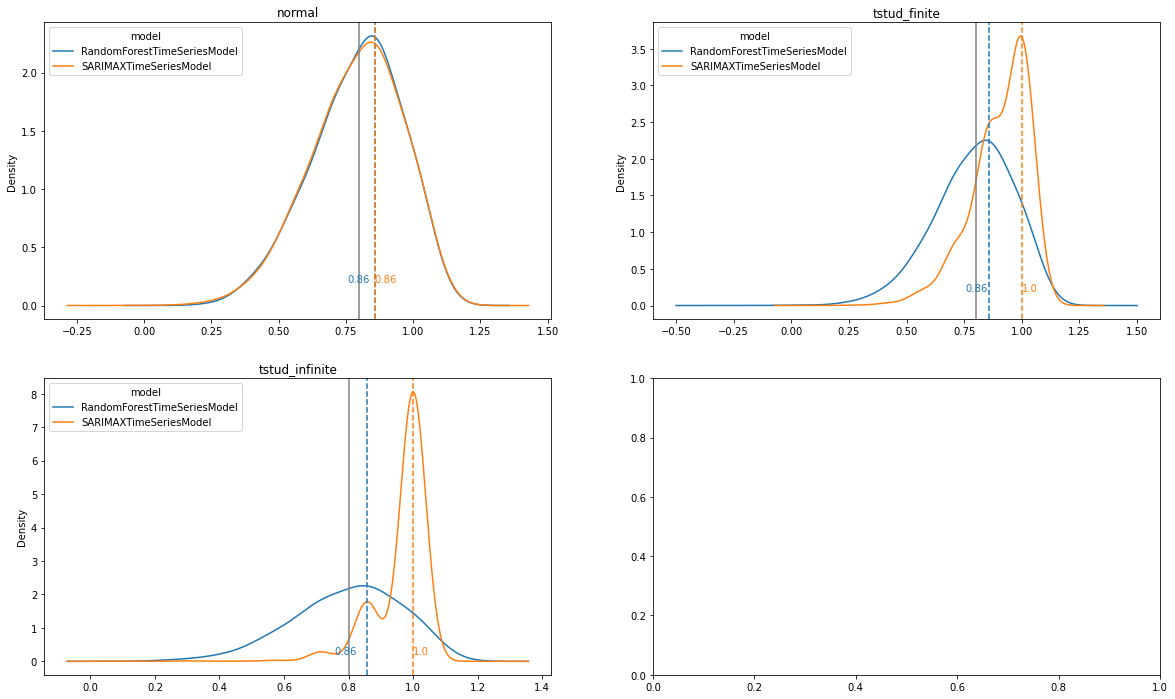

In [653]:
batch = 'daily_7ahead2'
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

plot_distr('normal', axes[0][0])

plot_distr('tstud_finite', axes[0][1])

plot_distr('tstud_infinite', axes[1][0])


In [662]:
subset = performance[(performance['distr'].str.contains('tstud_finite')) & (performance['batch']=='daily_7ahead2')]

est_09 = pd.pivot_table(data=subset, columns=['model'], index=['n'], aggfunc=lambda x: np.quantile(x, q=0.2), values='pi').reset_index()
est_01 = pd.pivot_table(data=subset, columns=['model'], index=['n'], aggfunc=lambda x: np.quantile(x, q=0.8), values='pi').reset_index()

In [663]:
#est_09

<AxesSubplot:title={'center':'Parameter estimates convergence'}, xlabel='n'>

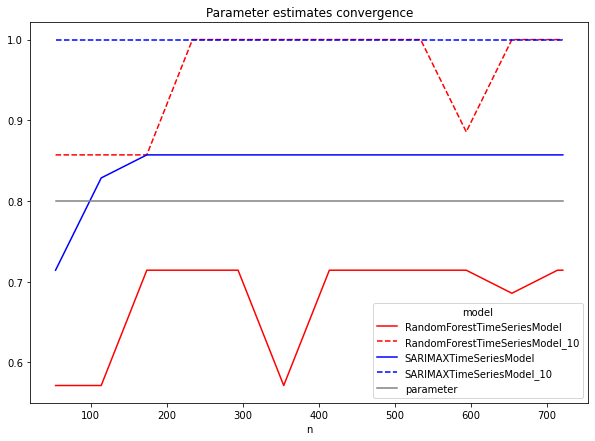

In [664]:
#est_09= est_09.rename(columns={'normal': 'normal_90', 'tstud_finite': 'tstud_finite_90', 'tstud_infinite': 'tstud_infinite_90'})
est_01= est_01.rename(columns={'RandomForestTimeSeriesModel': 'RandomForestTimeSeriesModel_10', 
                               'SARIMAXTimeSeriesModel': 'SARIMAXTimeSeriesModel_10'})

est_01['parameter'] = 0.8

ax = est_01.merge(est_09).plot.line(x='n', y=['RandomForestTimeSeriesModel', 'RandomForestTimeSeriesModel_10', 
                                              'SARIMAXTimeSeriesModel', 'SARIMAXTimeSeriesModel_10'], style=['-','--', '-','--'], color=['r', 'r', 'b', 'b'], title='Parameter estimates convergence', figsize=(10, 7))
est_01.merge(est_09).plot.line(x='n', y='parameter', ax=ax, color='grey')

<AxesSubplot:title={'center':'pi'}, xlabel='model'>

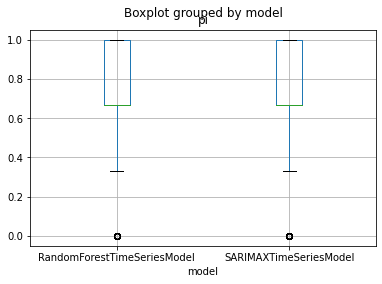

In [385]:
performance[(performance['distr']=='normal') & (performance['batch']=='monthly5_3ahead')].boxplot(column='pi', by='model')

<AxesSubplot:title={'center':'pi'}, xlabel='model'>

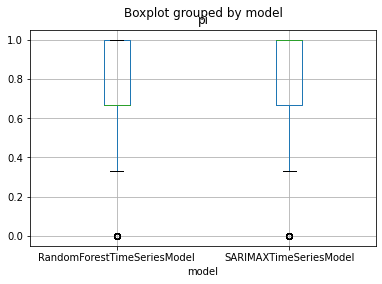

In [387]:
performance[(performance['distr']=='tstud_finite') & (performance['batch']=='monthly5_3ahead')].boxplot(column='pi', by='model')

<AxesSubplot:title={'center':'pi'}, xlabel='model'>

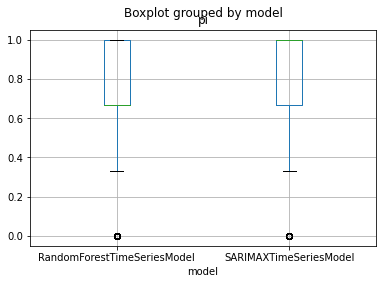

In [388]:
performance[(performance['distr']=='tstud_infinite') & (performance['batch']=='monthly5_3ahead')].boxplot(column='pi', by='model')

In [334]:
performance.head()

,mape,pi,fold,n,is_normal,model,id,model_details,data,distr,mc,batch
0,0.035198,0.857143,12,707,True,RandomForestTimeSeriesModel,0,daily_7ahead,AR,normal,0,daily_7ahead
1,0.038322,1.000000,11,647,True,RandomForestTimeSeriesModel,0,daily_7ahead,AR,normal,0,daily_7ahead
2,0.060414,0.571429,10,587,True,RandomForestTimeSeriesModel,0,daily_7ahead,AR,normal,0,daily_7ahead
3,0.033014,1.000000,9,527,False,RandomForestTimeSeriesModel,0,daily_7ahead,AR,normal,0,daily_7ahead
4,0.039444,1.000000,8,467,True,RandomForestTimeSeriesModel,0,daily_7ahead,AR,normal,0,daily_7ahead


In [403]:
normal = pd.pivot_table(data=performance, columns='distr', index=['batch', 'model'], aggfunc='mean', values='is_normal')
normal

distr                                          normal  tstud_finite  \
batch           model                                                 
daily_7ahead    RandomForestTimeSeriesModel  0.900000      0.033846   
                SARIMAXTimeSeriesModel       0.935747      0.014530   
monthly5_3ahead RandomForestTimeSeriesModel  0.837500      0.222500   
                SARIMAXTimeSeriesModel       0.913750      0.143421   

distr                                        tstud_infinite  
batch           model                                        
daily_7ahead    RandomForestTimeSeriesModel        0.002308  
                SARIMAXTimeSeriesModel             0.000000  
monthly5_3ahead RandomForestTimeSeriesModel        0.101250  
                SARIMAXTimeSeriesModel             0.065824

In [404]:
print(normal.to_latex())

\begin{tabular}{llrrr}
\toprule
                & distr &    normal &  tstud\_finite &  tstud\_infinite \\
batch & model &           &               &                 \\
\midrule
daily\_7ahead & RandomForestTimeSeriesModel &  0.900000 &      0.033846 &        0.002308 \\
                & SARIMAXTimeSeriesModel &  0.935747 &      0.014530 &        0.000000 \\
monthly5\_3ahead & RandomForestTimeSeriesModel &  0.837500 &      0.222500 &        0.101250 \\
                & SARIMAXTimeSeriesModel &  0.913750 &      0.143421 &        0.065824 \\
\bottomrule
\end{tabular}



In [432]:
mape = pd.pivot_table(data=performance, columns='distr', index=['batch', 'model'], aggfunc='mean', values='mape')
mape

distr                                              normal  tstud_finite  \
batch           model                                                     
daily_7ahead    RandomForestTimeSeriesModel  4.393220e-02      0.018803   
                SARIMAXTimeSeriesModel       3.675329e-02      0.014222   
monthly5_3ahead RandomForestTimeSeriesModel  4.308743e-02      0.023473   
                SARIMAXTimeSeriesModel       3.508480e+11   8279.578359   

distr                                        tstud_infinite  
batch           model                                        
daily_7ahead    RandomForestTimeSeriesModel    2.600030e+00  
                SARIMAXTimeSeriesModel         2.513864e+00  
monthly5_3ahead RandomForestTimeSeriesModel    2.279074e+01  
                SARIMAXTimeSeriesModel         3.571092e+07

In [441]:
print(mape.to_latex(float_format="{:0.1%}".format))

\begin{tabular}{llrrr}
\toprule
                & distr &            normal &  tstud\_finite &  tstud\_infinite \\
batch & model &                   &               &                 \\
\midrule
daily\_7ahead & RandomForestTimeSeriesModel &              4.4\% &          1.9\% &          260.0\% \\
                & SARIMAXTimeSeriesModel &              3.7\% &          1.4\% &          251.4\% \\
monthly5\_3ahead & RandomForestTimeSeriesModel &              4.3\% &          2.3\% &         2279.1\% \\
                & SARIMAXTimeSeriesModel & 35084803981224.3\% &     827957.8\% &   3571091609.3\% \\
\bottomrule
\end{tabular}



# Parameters

In [665]:
features.head()

,feature,impact,fold,model,n,id,model_details,data,distr,mc,batch
0,lag_7,1.0,12,RandomForestTimeSeriesModel,707,0,daily_7ahead,AR,normal,0,daily_7ahead
1,lag_7,1.0,11,RandomForestTimeSeriesModel,647,0,daily_7ahead,AR,normal,0,daily_7ahead
2,lag_7,1.0,10,RandomForestTimeSeriesModel,587,0,daily_7ahead,AR,normal,0,daily_7ahead
3,lag_7,1.0,9,RandomForestTimeSeriesModel,527,0,daily_7ahead,AR,normal,0,daily_7ahead
4,lag_7,1.0,8,RandomForestTimeSeriesModel,467,0,daily_7ahead,AR,normal,0,daily_7ahead


In [666]:
pd.pivot_table(data=features, columns=['distr'], index=['batch', 'model', 'feature'], aggfunc='mean', values='impact')

distr                                                       normal  \
batch           model                       feature                  
daily_7ahead    RandomForestTimeSeriesModel lag_7         1.000000   
                SARIMAXTimeSeriesModel      ar.S.L7       0.682626   
                                            intercept    31.722948   
                                            sigma2       20.399227   
daily_7ahead2   RandomForestTimeSeriesModel lag_7         1.000000   
                SARIMAXTimeSeriesModel      ar.S.L7       0.198504   
                                            converedg     0.991538   
                                            intercept    80.170380   
                                            sigma2       20.731612   
monthly5_3ahead RandomForestTimeSeriesModel lag_3         0.432420   
                                            lag_4         0.325629   
                                            lag_5         0.241950   
                SARIMAXTimeSeriesModel      ar.L1        -0.050442   
                                            ar.L2        -0.062228   
                                            ar.L3         0.393017   
                                            ar.L4        -0.395821   
                                            ar.L5        -0.206895   
                                            converedg     0.985000   
                                            intercept   130.507403   
                                            sigma2     5955.711062   

distr                                                  tstud_finite  \
batch           model                       feature                   
daily_7ahead    RandomForestTimeSeriesModel lag_7          1.000000   
                SARIMAXTimeSeriesModel      ar.S.L7        0.678774   
                                            intercept     32.103340   
                                            sigma2         8.295772   
daily_7ahead2   RandomForestTimeSeriesModel lag_7          1.000000   
                SARIMAXTimeSeriesModel      ar.S.L7        0.167903   
                                            converedg      0.980000   
                                            intercept     83.252426   
                                            sigma2         8.107374   
monthly5_3ahead RandomForestTimeSeriesModel lag_3          0.462751   
                                            lag_4          0.329182   
                                            lag_5          0.208067   
                SARIMAXTimeSeriesModel      ar.L1         -0.047702   
                                            ar.L2         -0.014614   
                                            ar.L3          0.420807   
                                            ar.L4         -0.413083   
                                            ar.L5         -0.226077   
                                            converedg      0.975000   
                                            intercept    125.300950   
                                            sigma2      1130.451073   

distr                                                  tstud_infinite  
batch           model                       feature                    
daily_7ahead    RandomForestTimeSeriesModel lag_7        1.000000e+00  
                SARIMAXTimeSeriesModel      ar.S.L7      6.801712e-01  
                                            intercept    4.549308e+01  
                                            sigma2       1.328098e+06  
daily_7ahead2   RandomForestTimeSeriesModel lag_7        1.000000e+00  
                SARIMAXTimeSeriesModel      ar.S.L7      1.935766e-01  
                                            converedg    9.946154e-01  
                                            intercept    8.059357e+01  
                                            sigma2       2.233384e+03  
monthly5_3ahead RandomForestTimeSeriesModel lag_3        4.838229e-01  
                                

In [559]:
features['feature']= features['feature'].replace({'lag_3': 'ar.L3','lag_4': 'ar.L4','lag_5': 'ar.L5'})

,feature,impact,fold,model,n,id,model_details,data,distr,mc,batch
14629,ar.L4,-0.420066,15,SARIMAXTimeSeriesModel,138,0,monthly5_3ahead,AR,normal,0,monthly5_3ahead
14637,ar.L4,-0.421634,14,SARIMAXTimeSeriesModel,129,0,monthly5_3ahead,AR,normal,0,monthly5_3ahead
14645,ar.L4,-0.419514,13,SARIMAXTimeSeriesModel,120,0,monthly5_3ahead,AR,normal,0,monthly5_3ahead
14653,ar.L4,-0.446994,12,SARIMAXTimeSeriesModel,111,0,monthly5_3ahead,AR,normal,0,monthly5_3ahead
14661,ar.L4,-0.455825,11,SARIMAXTimeSeriesModel,102,0,monthly5_3ahead,AR,normal,0,monthly5_3ahead


<AxesSubplot:xlabel='n'>

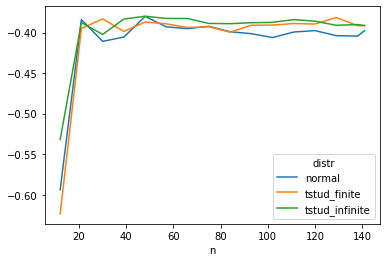

In [578]:
pd.pivot_table(data=subset, columns=['distr'], index=['n'], aggfunc=lambda x: np.quantile(x, q=0.5), values='impact').plot()

In [587]:
param = 'ar.L3'
value = 0.5

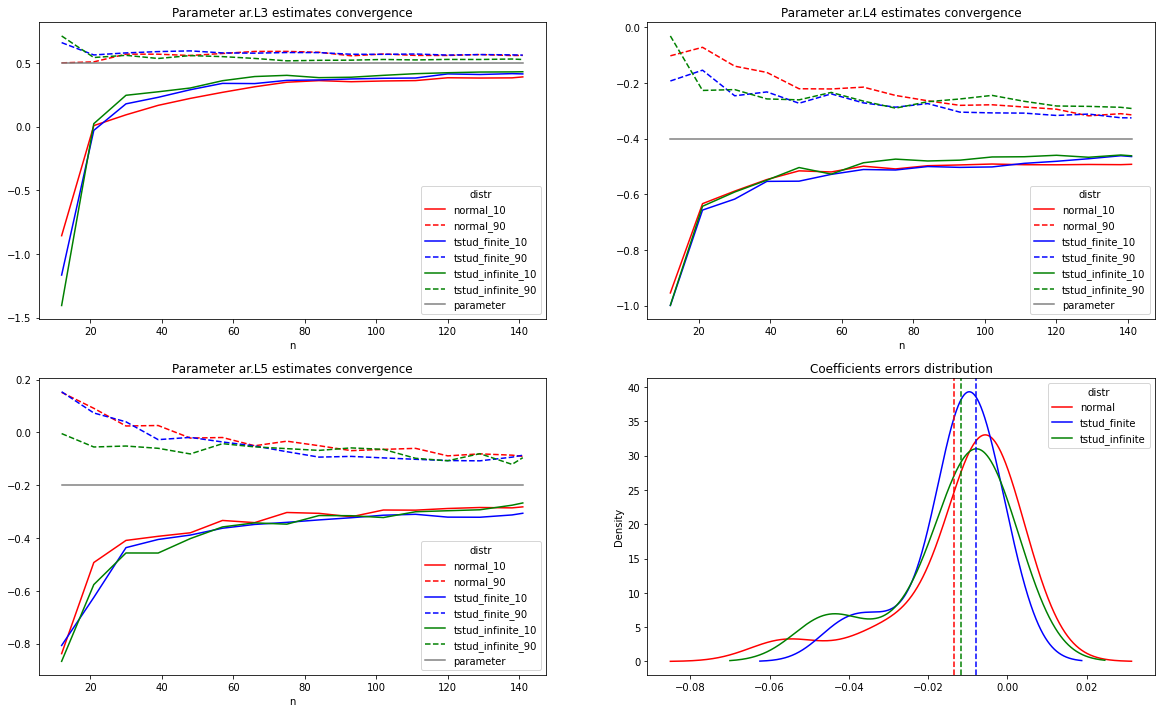

In [628]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

plot_conv('ar.L3', 0.5, axes[0][0])

plot_conv('ar.L4', -0.4, axes[0][1])

plot_conv('ar.L5', -0.2, axes[1][0])

subset = features[(features['n']>24) & (features['batch']==batch) & (features['feature'].isin(['ar.L3', 'ar.L4', 'ar.L5'])) & (features['model']=='SARIMAXTimeSeriesModel')]
merged = subset.merge(pd.DataFrame({'feature': ['ar.L3', 'ar.L4', 'ar.L5'], 'value': [0.5, -0.4, -0.2]}), on='feature')
merged['error'] = merged['impact'] - merged['value']
#merged['error'][merged['error']>-2].plot.hist(bins=50, title='Coefficients errors distribution (outliers excluded)', axes=axes[1][1])
pd.pivot_table(data=merged[merged['error']>-2], index='n', columns='distr', values='error').plot.kde(color=['r', 'b', 'g'], ax=axes[1][1], title='Coefficients errors distribution')
(axes[1][1]).axvline(merged[merged['distr']=='normal']['error'].median(), color='red', linestyle='--')
(axes[1][1]).axvline(merged[merged['distr']=='tstud_finite']['error'].median(), color='blue', linestyle='--')
(axes[1][1]).axvline(merged[merged['distr']=='tstud_infinite']['error'].median(), color='green', linestyle='--')

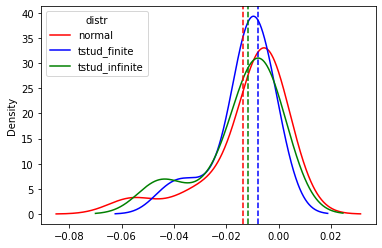

<AxesSubplot:title={'center':'Coefficients errors distribution'}, ylabel='Frequency'>

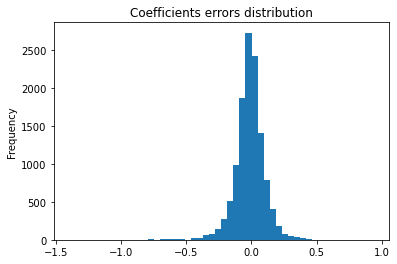

In [593]:
def plot_conv(param, value, ax):
    subset = features[(features['batch']==batch) & (features['feature'].isin([param])) & (features['model']=='SARIMAXTimeSeriesModel')]

    est_09 = pd.pivot_table(data=subset, columns=['distr'], index=['n'], aggfunc=lambda x: np.quantile(x, q=0.9), values='impact').reset_index()
    est_01 = pd.pivot_table(data=subset, columns=['distr'], index=['n'], aggfunc=lambda x: np.quantile(x, q=0.1), values='impact').reset_index()

    est_09= est_09.rename(columns={'normal': 'normal_90', 'tstud_finite': 'tstud_finite_90', 'tstud_infinite': 'tstud_infinite_90'})
    est_01= est_01.rename(columns={'normal': 'normal_10', 'tstud_finite': 'tstud_finite_10', 'tstud_infinite': 'tstud_infinite_10'})

    est_01['parameter'] = value

    est_01.merge(est_09).plot.line(x='n', y=['normal_10', 'normal_90', 'tstud_finite_10', 'tstud_finite_90', 'tstud_infinite_10', 'tstud_infinite_90'], style=['-','--', '-','--', '-','--'], color=['r', 'r', 'b', 'b', 'g', 'g'], title=f'Parameter {param} estimates convergence', ax=ax)
    est_01.merge(est_09).plot.line(x='n', y='parameter', ax=ax, color='grey')

In [581]:
import math
DEGREES = 2.1
DEGREES/(DEGREES-2)

20.999999999999982

In [376]:
import numpy as np

In [407]:
subset = features[(features['model'].str.contains('SARIMAXTimeSeriesModel')) & (features['feature']=='ar.S.L7') & (features['batch']=='daily_7ahead')]

#pd.pivot_table(data=subset, columns=['distr'], index=['n', 'mc'], aggfunc=lambda x: np.quantile(x, q=0.5), values='impact')

distr     normal  tstud_finite  tstud_infinite
n   mc                                        
54  0        NaN      0.619030        0.664452
    1   0.704412           NaN        0.741128
    2        NaN      0.542484        0.828525
    3   0.621899      0.680162        0.584982
    4   0.396744      0.632721        0.604335
...          ...           ...             ...
721 95  0.678042      0.689084        0.694134
    96  0.698100      0.691498        0.701590
    97  0.738944      0.652345        0.972410
    98  0.698491      0.675177        0.676547
    99       NaN      0.682660        0.704131

[1300 rows x 3 columns]

<AxesSubplot:title={'center':'Parameter estimates convergence'}, xlabel='n'>

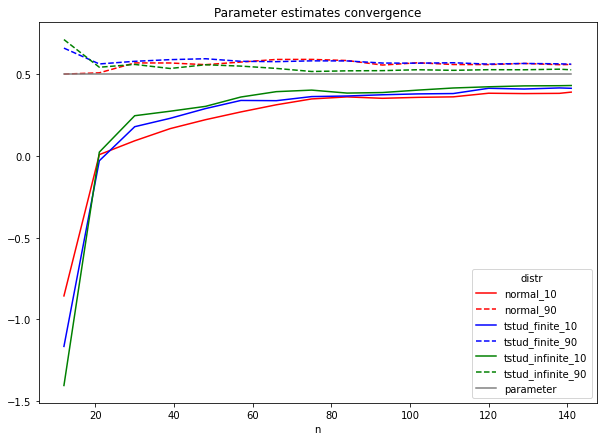

In [572]:
est_09 = pd.pivot_table(data=subset, columns=['distr'], index=['n'], aggfunc=lambda x: np.quantile(x, q=0.9), values='impact').reset_index()
est_01 = pd.pivot_table(data=subset, columns=['distr'], index=['n'], aggfunc=lambda x: np.quantile(x, q=0.1), values='impact').reset_index()

est_09= est_09.rename(columns={'normal': 'normal_90', 'tstud_finite': 'tstud_finite_90', 'tstud_infinite': 'tstud_infinite_90'})
est_01= est_01.rename(columns={'normal': 'normal_10', 'tstud_finite': 'tstud_finite_10', 'tstud_infinite': 'tstud_infinite_10'})

est_01['parameter'] = 0.5

ax = est_01.merge(est_09).plot.line(x='n', y=['normal_10', 'normal_90', 'tstud_finite_10', 'tstud_finite_90', 'tstud_infinite_10', 'tstud_infinite_90'], style=['-','--', '-','--', '-','--'], color=['r', 'r', 'b', 'b', 'g', 'g'], title='Parameter estimates convergence', figsize=(10, 7))
est_01.merge(est_09).plot.line(x='n', y='parameter', ax=ax, color='grey')

<AxesSubplot:title={'center':'Parameter estimates convergence'}, xlabel='n'>

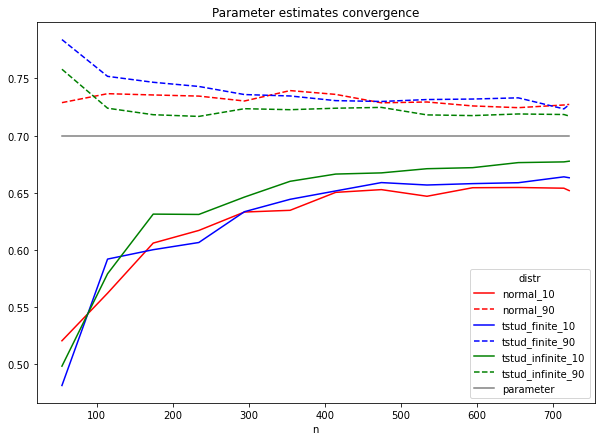

In [428]:
est_09= est_09.rename(columns={'normal': 'normal_90', 'tstud_finite': 'tstud_finite_90', 'tstud_infinite': 'tstud_infinite_90'})
est_01= est_01.rename(columns={'normal': 'normal_10', 'tstud_finite': 'tstud_finite_10', 'tstud_infinite': 'tstud_infinite_10'})

est_01['parameter'] = 0.7

ax = est_01.merge(est_09).plot.line(x='n', y=['normal_10', 'normal_90', 'tstud_finite_10', 'tstud_finite_90', 'tstud_infinite_10', 'tstud_infinite_90'], style=['-','--', '-','--', '-','--'], color=['r', 'r', 'b', 'b', 'g', 'g'], title='Parameter estimates convergence', figsize=(10, 7))
est_01.merge(est_09).plot.line(x='n', y='parameter', ax=ax, color='grey')

<AxesSubplot:xlabel='n'>

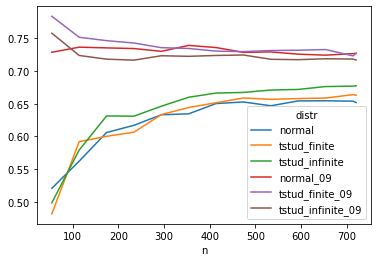

In [410]:
est_01.merge(est_09.rename(columns={'normal': 'normal_09', 'tstud_finite': 'tstud_finite_09', 'tstud_infinite': 'tstud_infinite_09'})).plot(x='n', y=['normal', 'tstud_finite', 'tstud_infinite', 'normal_09', 'tstud_finite_09', 'tstud_infinite_09'])

In [ ]:
# spr krótsze dane, trzy lata miesięcznie, prognoza na miesiąc wprzód
# jak (nie) działa zgadywanie rzędu
# spr więcej parameterów